朴素贝叶斯(Naive Bayes, NB)和支持向量机(Support Vector Machines, SVM)的变体常被用作文本分类的基线方法，但它们的性能因模型变体、使用的特性和任务/数据集的不同而有很大差异。Sida Wang 和 Christopher D. Manning基于两种算法的特质，提出了NBSVM算法，实验证明，NBSVM在情绪分析数据集上优于大多数算法的结果，甚至有时能达到start-of-the-art,因此在文本分类中常被作为一个有用的baseline。本文将结合kaggle上的有毒评论分类任务详细介绍NBSVM算法。



**导入算法库**

导入我们需要的算法库，如果你没有安装此算法库，可以pip安装一下。

In [3]:
import pandas as pd, numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

**导入数据**

导入有毒评论分类数据，该数据集可以在kaggle上下载，也可以在我的网盘上下载：https://share.weiyun.com/5c7KYLw

In [4]:
train = pd.read_csv('input/train.csv').fillna(" ") #填空行
test = pd.read_csv('input/test.csv').fillna(" ")

**查看数据**

训练数据包含每行id、评论文本和6个我们将尝试预测的不同标签。

In [5]:
train.head()
train.shape

(159571, 8)

**分析评论文本数据的长度**

句子长度的平均值: 67.86696204197504  句子长度的方差: 100.52020389688741  句子长度的最大值: 2273


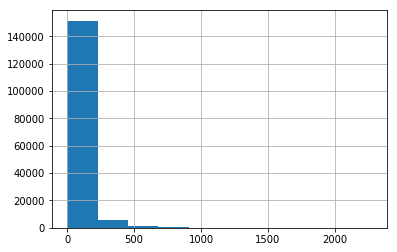

In [24]:
lens = train.comment_text.map(lambda x: len(x.split(" ")))
print("句子长度的平均值:",lens.mean()," 句子长度的方差:", lens.std(), " 句子长度的最大值:",lens.max())
lens.hist();

In [27]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# train[label_cols].describe()
train['none'] = 1-train[label_cols].max(axis=1)  #主要是看多少个评论没有表情
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**建立模型**

我们首先对一列无意义的字符串正则匹配，去掉这些无意义的，利用tfidf提取单词的特征，使用ngram，得到1-ngram 或者2-ngram 特征，就像NBSVM论文中建议的那样。

In [6]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [14]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,analyzer='word',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train["comment_text"])
test_term_doc = vec.transform(test["comment_text"])

KeyboardInterrupt: 

这将创建一个只有少量非零元素(存储在下面的表示中)的稀疏矩阵。

In [ ]:
trn_term_doc, test_term_doc


**NBSVM模型**


In [10]:
x = trn_term_doc
test_x = test_term_doc

下面是基本的朴素贝叶斯特征方程，公式可以参考论文

In [12]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = SVC(C=4,kernel='linear',probability=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


**参考**

1、Wang S, Manning C D. Baselines and bigrams: Simple, good sentiment and topic classification[C]//Proceedings of the 50th Annual Meeting of the Association for Computational Linguistics: Short Papers-Volume 2. Association for Computational Linguistics, 2012: 90-94.

2、https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline